In [23]:
import pandas as pd
import os
import numpy as np
import pandas_profiling

# This line is needed to display plots inline in Jupyter Notebook
%matplotlib inline

# Required for basic python plotting functionality
import matplotlib.pyplot as plt

# Required for formatting dates later in the case
import datetime
import matplotlib.dates as mdates

# Required to display image inline
from IPython.display import Image

# Advanced plotting functionality with seaborn
import seaborn as sns
sns.set(style="whitegrid") # can set style depending on how you'd like it to look

import folium  #needed for interactive map
from folium.plugins import HeatMap

import geopandas
from shapely.geometry import Polygon
from shapely.geometry import Point
from geopandas import GeoDataFrame

plotsize = (15,6)

In [2]:
path = 'Dataset/Parquets'
mta_trips = pd.read_parquet(path + '/mta_trips_filtered.parquet', engine = 'pyarrow')

### Maps

#### Heatmap

In [3]:
max_amount = float(mta_trips['new_entries'].max())

folium_hmap = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")

hm_wide = HeatMap( list(zip(mta_trips['latitude'], mta_trips['longitude'], 
                            mta_trips['new_entries'])),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=8, blur=6, 
                   max_zoom=15, 
                 )

folium_hmap.add_child(hm_wide);
path = 'Results'
folium_hmap.save(path + "/Maps/heatmap_mta_trips.html")

#### Markmap

In [4]:
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")

mta_trips = mta_trips.reset_index()

for i in range(0,1000):
    marker = folium.CircleMarker(location=[mta_trips["latitude"][i],
                                           mta_trips["longitude"][i]],
                                 radius=5,color="b",fill=True)
    marker.add_to(folium_map)
    
path = 'Results'   
folium_map.save(path + "/Maps/markmap_mta_trips.html")

### Trip graphs

In [5]:
path = 'Dataset/Parquets'
mta_trips = pd.read_parquet(path + '/mta_trips_nta.parquet', engine = 'pyarrow')

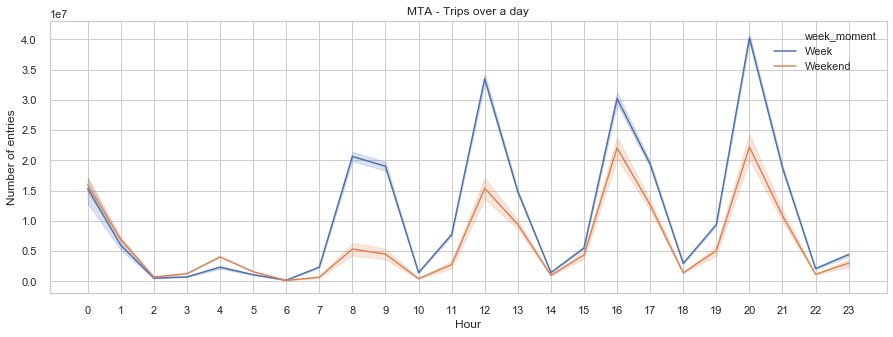

In [6]:
mta_trips['hour'] = mta_trips['datetime'].dt.hour
mta_trips['weekday'] = mta_trips['datetime'].dt.dayofweek
mta_trips['week_moment'] = np.where(mta_trips['weekday'] <= 4, 'Week', 'Weekend')
mta_trips['weekday'] = np.where(mta_trips['weekday'] == 0, 'Monday',
                                           np.where(mta_trips['weekday'] == 1, 'Tuesday',
                                                   np.where(mta_trips['weekday'] == 2, 'Wednesday',
                                                           np.where(mta_trips['weekday'] == 3, 'Thursday',
                                                                   np.where(mta_trips['weekday'] == 4, 'Friday',
                                                                           np.where(mta_trips['weekday'] == 5, 'Saturday', 'Sunday'))))))

Trips_hour = mta_trips.groupby(['hour', 'weekday', 'week_moment'])['longitude'].count().reset_index()
Trips_hour['new_entries'] = mta_trips.groupby(['hour', 'weekday', 'week_moment'])['new_entries'].sum().reset_index()['new_entries']

fig, ax = plt.subplots(figsize = plotsize)
m = sns.lineplot(x="hour", y="new_entries", hue = 'week_moment', data=Trips_hour, ax=ax)
ax.set(xlabel='Hour', ylabel='Number of entries')
ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 18000)
plt.title('MTA - New entries over a day');
path = 'Results'
plt.savefig(path + '/Images/mta_entries_hour_week.png')

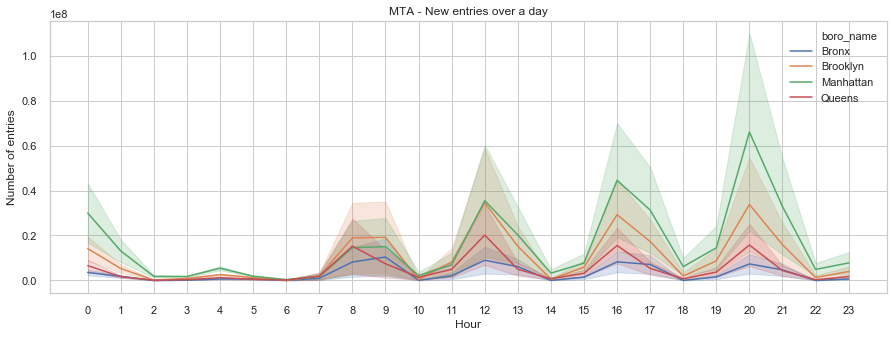

In [13]:
mta_trips['hour'] = mta_trips['datetime'].dt.hour
mta_trips['weekday'] = mta_trips['datetime'].dt.dayofweek
mta_trips['week_moment'] = np.where(mta_trips['weekday'] <= 4, 'Week', 'Weekend')
mta_trips['weekday'] = np.where(mta_trips['weekday'] == 0, 'Monday',
                                           np.where(mta_trips['weekday'] == 1, 'Tuesday',
                                                   np.where(mta_trips['weekday'] == 2, 'Wednesday',
                                                           np.where(mta_trips['weekday'] == 3, 'Thursday',
                                                                   np.where(mta_trips['weekday'] == 4, 'Friday',
                                                                           np.where(mta_trips['weekday'] == 5, 'Saturday', 'Sunday'))))))

Trips_hour = mta_trips.groupby(['hour', 'boro_name', 'week_moment'])['longitude'].count().reset_index()
#Accidents_Hour['HOUR'] = Accidents_Hour['HOUR'].astype('str')
Trips_hour['new_entries'] = mta_trips.groupby(['hour', 'boro_name', 'week_moment'])['new_entries'].sum().reset_index()['new_entries']
#Trips_hour = Trips_hour.loc[Trips_hour['boro_name'] != 'Manhattan']


fig, ax = plt.subplots(figsize = plotsize)
m = sns.lineplot(x="hour", y="new_entries", hue = 'boro_name', data=Trips_hour, ax=ax)
ax.set(xlabel='Hour', ylabel='Number of entries')
ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 18000)
plt.title('MTA - New entries over a day');
path = 'Results'
plt.savefig(path + '/Images/mta_entries_hour_borough.png')

#### Boxplots

In [14]:
path = 'Dataset/Parquets'
mta_trips = pd.read_parquet(path + '/mta_trips_filtered.parquet', engine = 'pyarrow')

In [15]:
mta_trips['pickup_month_dt'] = pd.to_datetime(mta_trips['datetime']).dt.to_period('M')
mta_trips['pickup_date'] = pd.to_datetime(mta_trips['datetime']).dt.to_period('d')
mta_trips['pickup_hour'] = pd.to_datetime(mta_trips['datetime']).dt.hour
mta_trips['pickup_weekday'] = mta_trips['datetime'].dt.dayofweek
mta_trips['weekend'] = np.where(mta_trips['pickup_weekday'] <= 4, False, True)
mta_trips['rush'] = np.where(((mta_trips['pickup_hour'] >= 6) & (mta_trips['pickup_hour'] <= 9)) |
                               ((mta_trips['pickup_hour'] >= 15) & (mta_trips['pickup_hour'] <= 20)), True, False)

In [16]:
mta_trips_day = mta_trips.groupby(['pickup_month_dt', 'pickup_date', 'weekend', 'rush'])['new_entries'].count().reset_index(name = 'trips')
mta_trips_day['new_entries'] = mta_trips.groupby(['pickup_month_dt', 'pickup_date', 'weekend', 'rush'])['new_entries'].sum().reset_index()['new_entries']#['new_entries']
mta_trips_day.head()

,pickup_month_dt,pickup_date,weekend,rush,trips,new_entries
0,2014-03,2014-03-29,True,False,8117,1017227
1,2014-03,2014-03-29,True,True,8732,1568051
2,2014-03,2014-03-30,True,False,11336,1204483
3,2014-03,2014-03-30,True,True,8604,1241499
4,2014-03,2014-03-31,False,False,11519,1914322


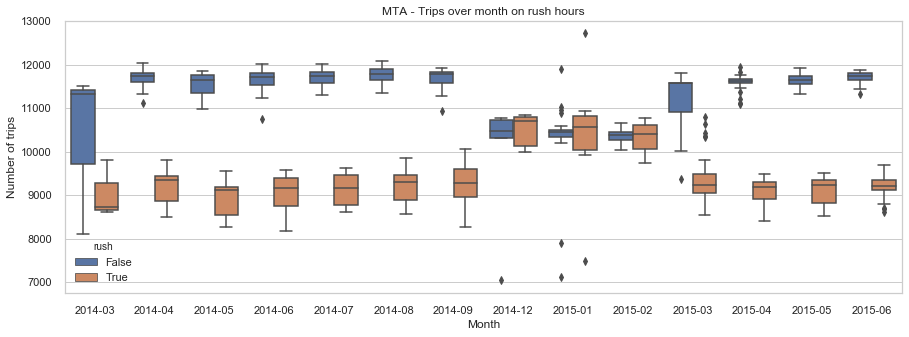

In [17]:
fig, ax = plt.subplots(figsize = plotsize)
m = sns.boxplot(x="pickup_month_dt", y="trips", hue = 'rush', data=mta_trips_day, ax=ax)
ax.set(xlabel='Month', ylabel='Number of trips')
#ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 18000)
plt.title('MTA - Trips over month on rush hours');
path = 'Results'
plt.savefig(path + '/Images/mta_trips_month_rush.png')

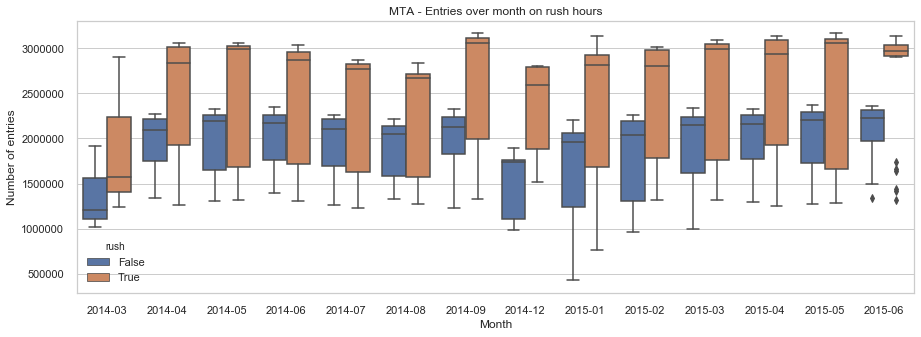

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
m = sns.boxplot(x="pickup_month_dt", y="new_entries", hue = 'rush', data=mta_trips_day, ax=ax)
ax.set(xlabel='Month', ylabel='Number of entries')
#ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 18000)
plt.title('MTA - Entries over month on rush hours');
path = 'Results'
plt.savefig(path + '/Images/mta_entries_month_rush.png')

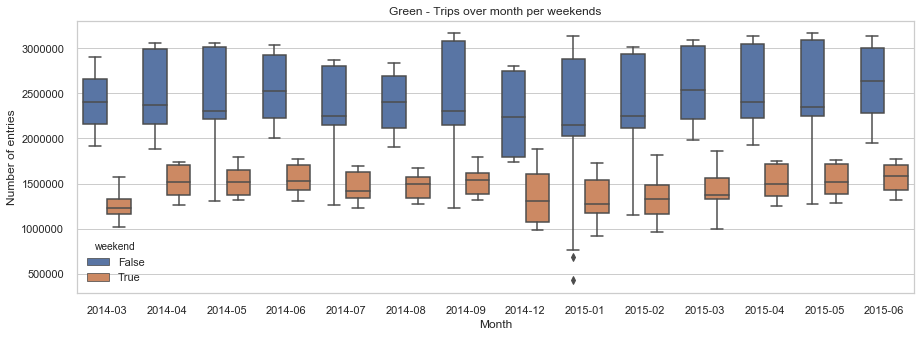

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
m = sns.boxplot(x="pickup_month_dt", y="new_entries", hue = 'weekend', data=mta_trips_day, ax=ax)
ax.set(xlabel='Month', ylabel='Number of entries')
#ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 18000)
plt.title('Green - Trips over month per weekends');
path = 'Results'
plt.savefig(path + '/Images/mta_entries_month_weekend.png')